LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [11]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader

In [12]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


# Prepare input data

Here we compute the optimization input variables, the vector $\EMean$ of expected returns, and the covariance matrix $\ECov$, from raw data. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [13]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)   

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [14]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [15]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data()
df_prices, _ = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



## Compute yearly return statistics

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix. The below logic is implemented also in the `portfolio_tools` module as a function. It is used in the other notebooks.  

### 1. Compute weekly logarithmic return

First we convert the daily prices to weekly prices.

In [16]:
df_weekly_prices = df_prices.resample('W').last()

Convert the weekly prices to weekly logarithmic return.

In [17]:
df_weekly_log_returns = np.log(df_weekly_prices) - np.log(df_weekly_prices.shift(1))
df_weekly_log_returns = df_weekly_log_returns.dropna(how='all')
df_weekly_log_returns = df_weekly_log_returns.fillna(0)

We can see based on the histograms that the distribution of weekly logarithmic return is approximately normal.

array([[<AxesSubplot:title={'center':'PM'}>, <AxesSubplot:title={'center':'LMT'}>,
        <AxesSubplot:title={'center':'MCD'}>],
       [<AxesSubplot:title={'center':'MMM'}>, <AxesSubplot:title={'center':'AAPL'}>,
        <AxesSubplot:title={'center':'MSFT'}>],
       [<AxesSubplot:title={'center':'TXN'}>, <AxesSubplot:title={'center':'CSCO'}>, <AxesSubplot:>]], dtype=object)

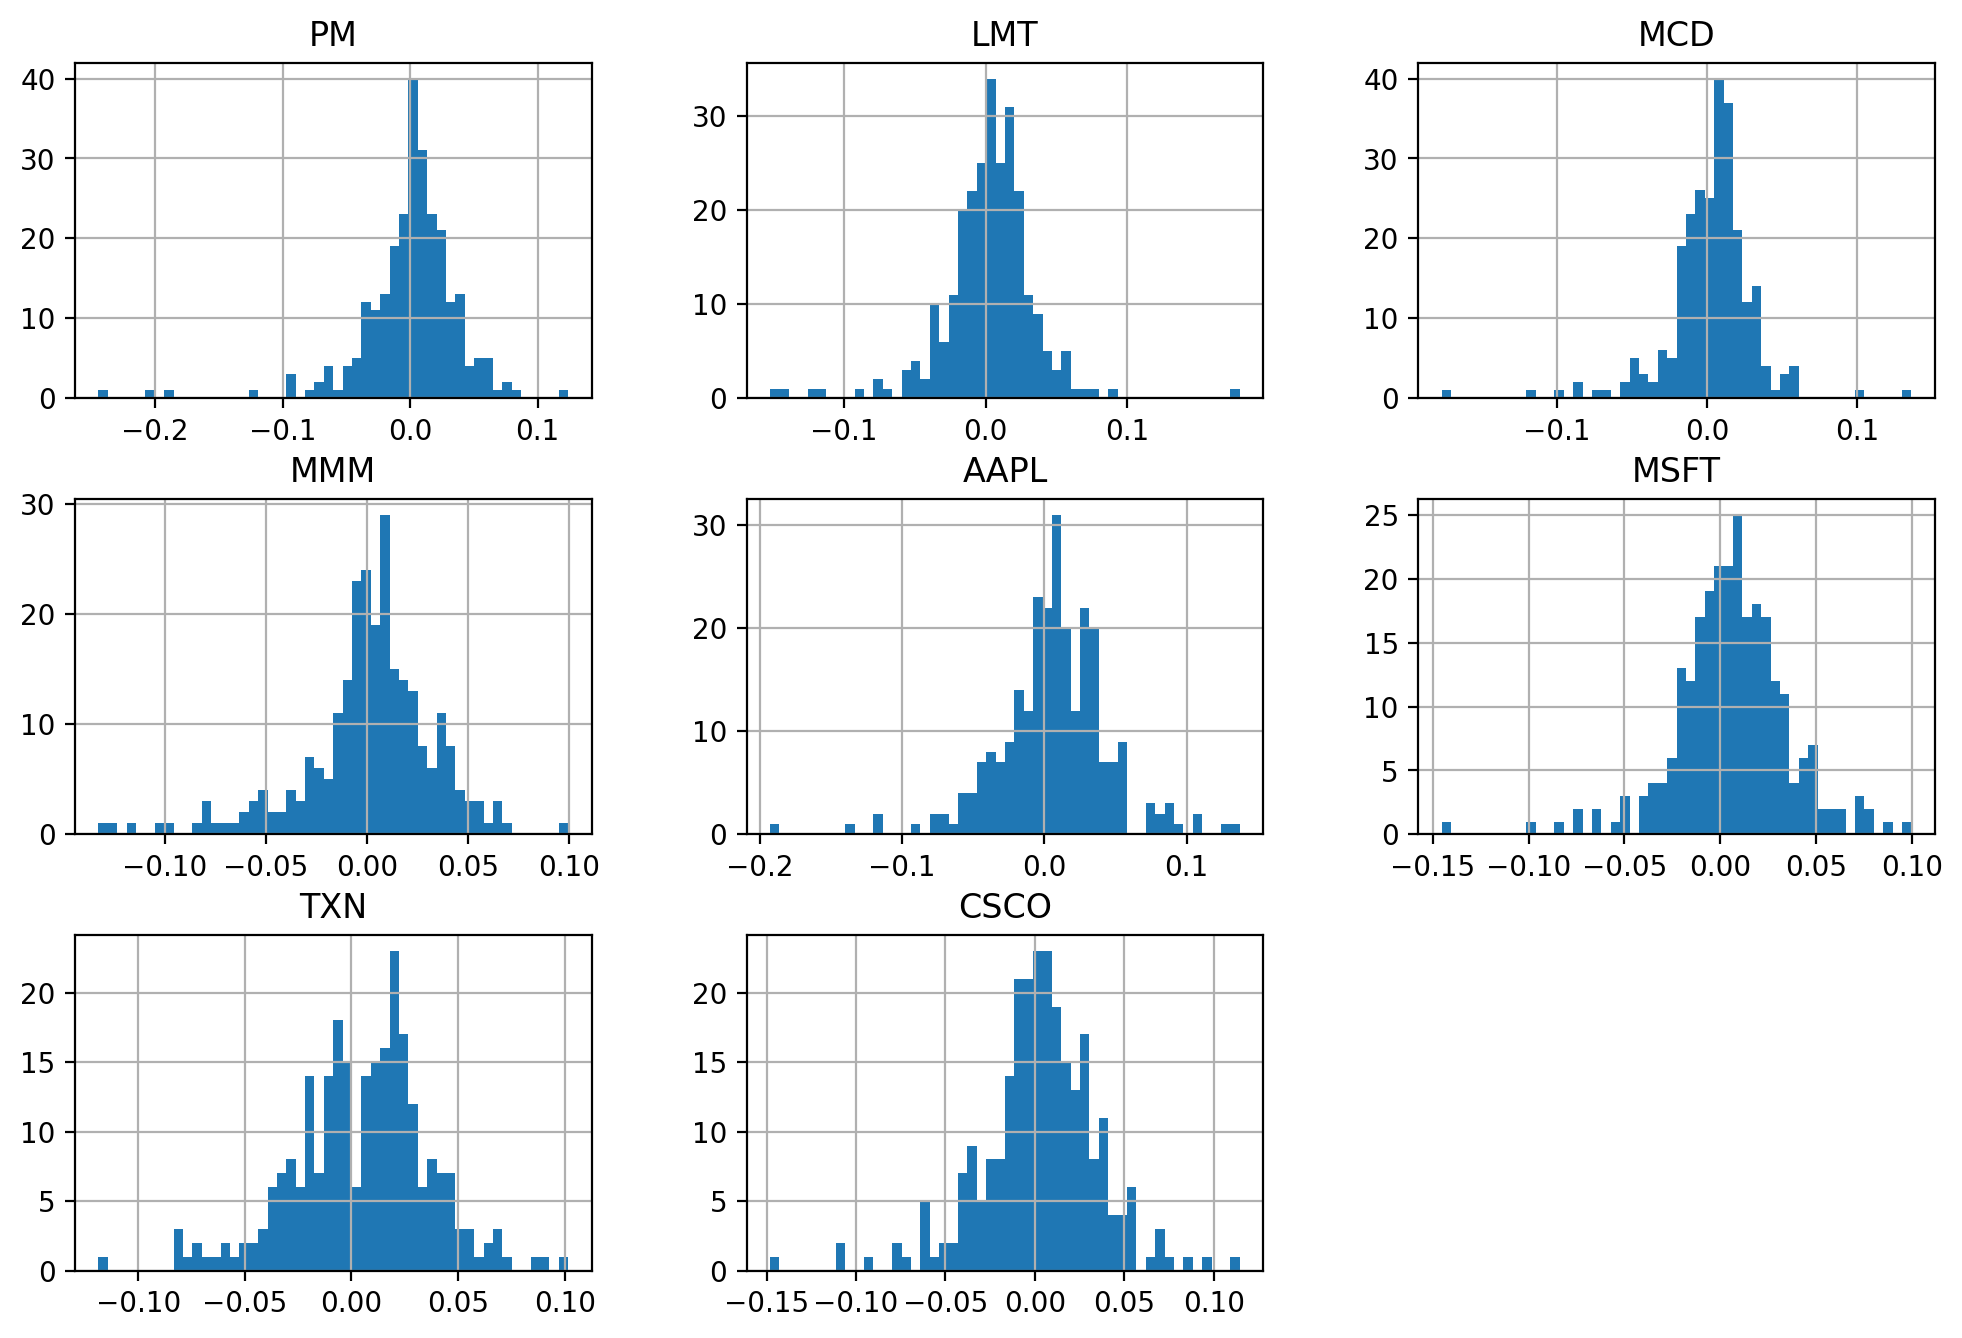

In [18]:
df_weekly_log_returns.hist(bins=50)

### 2. Compute the distribution of weekly logarithmic return

Assuming that the distribution is normal, we estimate the mean and covariance of the weekly logarithmic return.

In [19]:
return_array = df_weekly_log_returns.to_numpy()
T = return_array.shape[0]
m_weekly_log = np.mean(return_array, axis=0)
S_weekly_log = np.cov(return_array.transpose())

### 3. Project the distribution to the investment horizon

Next we project the logarithmic return statistics to the investment horizon of 1 year.

In [20]:
m_log = 52 * m_weekly_log
S_log = 52 * S_weekly_log

### 4. Compute the distribution of yearly linear return

We recover the distribution of prices from the distribution of logarithmic returns.

In [21]:
p_0 = df_weekly_prices.iloc[0].to_numpy()
m_P = p_0 * np.exp(m_log + 1/2*np.diag(S_log))
S_P = np.outer(m_P, m_P) * (np.exp(S_log) - 1)

Finally we convert the distribution of prices to the distribution of yearly linear returns.

In [22]:
m = 1 / p_0 * m_P - 1
S = 1 / np.outer(p_0, p_0) * S_P